In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import math
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

In [ ]:
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"
FileName = "2024_07_09_11_30_174.jpg"
raw_img = cv.imread(Directory + "/" + FileName)
img = cv.cvtColor(raw_img, cv.COLOR_BGR2GRAY)
img = raw_img

In [1]:
def resize(frame, width = 640, height = 640):
    return cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)
def InferenceImage(model, frame):
    results = model(resize(frame), conf=0.3, save=True, show_labels=False, retina_masks=True)
    return results

# Visibility Estimation

In [2]:
def edge_detection(img):    
    gradx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    grady = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
    return gradx, grady

def blurimage(img, kernelsize):
    return cv.GaussianBlur(img, (kernelsize, kernelsize), 0)

def convertgray(img):    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

def preprocess(img, kernelsize):
    gray_img = convertgray(img)
    img_blur = blurimage(gray_img, kernelsize)
    gradx, grady = edge_detection(img_blur)
    grad_mag = cv.magnitude(gradx, grady)
    grad_mag_norm = cv.normalize(grad_mag, None, 0, 255, cv.NORM_MINMAX)
    return grad_mag_norm

def count_edges(target_img, kernelsize, multiplier):
    preprocessed_img = preprocess(target_img, kernelsize)
    _, thresh = cv.threshold(preprocessed_img, multiplier * np.median(preprocessed_img), 255, cv.THRESH_BINARY)             
    total_edges = np.count_nonzero(thresh)
    return total_edges

def edge_strength_ratio(ref_edge, target_edge):
    return np.round((target_edge / ref_edge),2)

In [ ]:
gaussian_kernel = 5
multiplier = 5
ref_edge = count_edges(ref_image, kernelsize, multiplier)
curr_edge = count_edges(image, kernelsize, multiplier)
edge_strength = np.round((curr_edge / ref_edge),2)

In [20]:
def calcFrames(start, end, fps, offset=200):
    startFrame = (int(start[0]) * 60 + int(start[1])) * fps
    endFrame = (int(end[0]) * 60 + int(end[1])) * fps 
    return startFrame-offset, endFrame+offset

In [2]:
data = pd.read_csv(r"F:\Work\SOCAAutomation\Dataset\Book1.csv")
data.head()

NameError: name 'pd' is not defined

# Build Features

In [45]:
## 



# Main

In [47]:
# Configurations
model_file = r"F:\Work\SOCAAutomation\Models\11_04_2025\best.pt"
video_file = r"F:\Work\SOCAAutomation\Dataset\Converted\04_07_2024\AXIS 213 - 10.1.5.173 2024-07-04_11_51_08_772.mp4"
data = pd.read_csv(r"F:\Work\SOCAAutomation\Dataset\Book1.csv")
data_grp = data.groupby(['Folder', 'Video File'])[['Start Time', 'End Time']].agg(list)
start_list = data_grp.iloc[0]['Start Time']
end_list = data_grp.iloc[0]['End Time']
fps = 30

In [25]:
print("Start Frame: {} and End Frame {} is recalculated...".format(5,  10))

Start Frame: 5 and End Frame 10 is recalculated...


In [ ]:
# Load Model
# REINSTALL ULTRALYTICS 8.2.103 #model = YOLO(model_file, task='segment')


# Load video
video = cv.VideoCapture(video_file)

# Loop over frames

count_frame = 0
frame_referenced = False
subseg_det = false
subseg_ind = 0
start_frame, end_frame = calcFrames(start_list[subseg_ind].split(":"), end_list[subseg_ind].split(":"), fps):
while True:
    ret, frame = video.read()
    count_frame += 1 
    if ret:               
        if frame_referenced is False and count_frame > 10 and count_frame < 100:
            # Build reference image
            ref_image = resize(frame)
            ref_edge = count_edges(ref_image, kernelsize, multiplier)
            frame_referenced = True
            print("Reference Frame detected and Reference edge is {}".format(ref_edge))
        if count_frame >= start_frame and count_frame <= end_frame:
            subseg_det = True
            print("Subsegment {} is detected...".format(subseg_ind + 1))
            
        elif subseg_det is True:
            subseg_det = False
            ind += 1            
            start_frame, end_frame = calcFrames(start_list[subseg_ind].split(":"), end_list[subseg_ind].split(":"), fps)
            print("Start Frame: {} and End Frame {} is recalculated...".format(start_frame,  end_frame))
    else:
        if subseg_det is True:
            print("{} frame is missing".format(count_frame))
            
        



# Reference Images Visibility: Once for one experiment
# Load Reference image
# Estimate visibility

# Loop over subsegments of video

# Inference image

# Build Features



# Testing

In [121]:
test_img_path = r"F:\Work\SOCAAutomation\Dataset\TestImages\TwoFire.jpg"
#model_file = r"F:\Work\SOCAAutomation\Models\11_04_2025\best.pt"
model_file = r"F:\Work\SOCAAutomation\Models\28_08_2024\best_yolov8m_seg.pt"
model2 = YOLO(model_file)#, task='segment')
test_img = cv.imread(test_img_path)
test_img_resized = resize(test_img)

In [124]:
results = model2(test_img_resized, conf=0.3, save=True, show_labels=False, retina_masks=True)


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4263.9ms
Speed: 10.0ms preprocess, 4263.9ms inference, 773.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict13


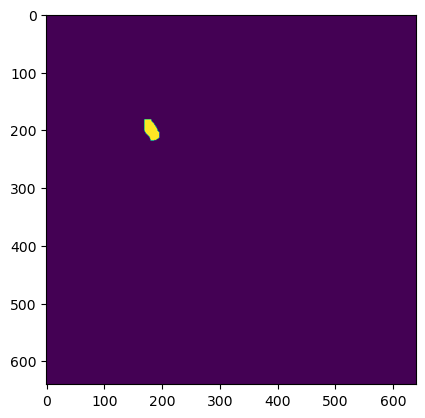

In [125]:
plt.imshow(results[0].masks.data[0])


In [90]:
def findCentroid(mask_img):
    contours, hierarchies = cv.findContours(mask_img.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    points = []
    area = []
    if len(contours) > 0:
        for i in contours:            
            M = cv.moments(i)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                points.append([cx, cy])
                area.append(M['m00'])
    return points, area, contours, hierarchies

In [93]:
mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
mask_img

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [94]:
boolean_masks = np.any(np.array(results[0].masks[:].data), axis=0)
Centroids, Area, Contours, hierarchies = findCentroid(boolean_masks)


In [177]:
test = np.array(results[0].boxes.data[0])
np.round(abs(test[0] - test[2]), 0)
# width = x1 - x2

26.0

In [ ]:
mask_area = []
mask_centroid = []
bbox_area = []
bbox_centroid = []
bbox_dim = []
mask_conf = []
if results[0].masks is not None:
    n_contours = len(results[0].masks)
    masks = results[0].masks.data
    bboxes = results[0].boxes
    # Bounding Box Parameters
    mask_conf = list(np.array(bboxes.conf))
    bbox_data = np.array(results[0].boxes.data)
    for box in bbox_data:
        width = np.round(np.round(abs(box[0] - box[2]))
        height = np.round(abs(box[1] - box[3]))
        bbox_dim.append([width, height])
        
    # Mask Parameters
    for mask in masks:
        mask_area.append(np.count_nonzero(mask))
        mask_centroid.append(np.round(np.mean(np.where(mask), axis=1)).astype('int'))

In [ ]:
preprocessed_img = preprocess(img, gaussian_kernel)
med = np.median(preprocessed_img)
ret, thresh = cv.threshold(preprocessed_img, multiplier*med, 255, cv.THRESH_BINARY)
total_edges.append(np.count_nonzero(thresh))
img_transform.append(thresh)
gray_images.append(convertgray(path + "/" + frames[i]))
plot_images2by2(img_transform[i], gray_images[i])
plt.title(str(med) + ", " + str(np.mean(preprocessed_img)))